In [1]:
import pandas as pd
import numpy as np

# f1 should be [4.5] mag and f2 should be [24] mag
def alpha(f1,f2):
    y = 0.55*(f1-f2)-2.94
    return y


def mJy_to_mag(F, F0):
    m = -2.5*np.log10(F*0.001/F0)
    return m


def e_mJy_to_mag(e_F, F):
    m = (2.5/np.log(10))*(e_F/F)
    return m

# c2d CLOUDS/CORES

In [14]:
# c2d = pd.read_csv("../Data/c2d_CLOUDS_HREL.csv")
c2d = pd.read_csv("../Data/c2d_CORES_HREL.csv",index_col=1)
# print(c2d.info())

c2d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109119 entries, SSTc2d J080834.0-355507 to SSTc2d J220650.5+590416
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        109119 non-null  object 
 1   ra            109119 non-null  float64
 2   dec           109119 non-null  float64
 3   alpha         109119 non-null  float64
 4   object_type   109119 non-null  object 
 5   j_flux_c      77553 non-null   float64
 6   j_d_flux_c    70380 non-null   float64
 7   h_flux_c      77553 non-null   float64
 8   h_d_flux_c    73398 non-null   float64
 9   ks_flux_c     77553 non-null   float64
 10  ks_d_flux_c   69770 non-null   float64
 11  ir1_flux_c    97120 non-null   float64
 12  ir1_d_flux_c  97119 non-null   float64
 13  ir2_flux_c    91384 non-null   float64
 14  ir2_d_flux_c  91384 non-null   float64
 15  ir3_flux_c    97233 non-null   float64
 16  ir3_d_flux_c  97233 non-null   float64
 17  ir4_flux_c    

In [15]:
c2d_IRAC = c2d[["object_type","region","ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c"]]
c2d_IRAC = c2d_IRAC[~c2d_IRAC["ir1_d_flux_c"].isna() & ~c2d_IRAC["ir2_flux_c"].isna() & ~c2d_IRAC["ir3_flux_c"].isna() & ~c2d_IRAC["ir4_flux_c"].isna() & ~c2d_IRAC["mp1_flux_c"].isna()]
print(c2d_IRAC.shape)

# Load in magnitude data
# Access data by band instead of object
c2d_IRAC_fluxes = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c"]].values.astype(float).transpose() 
band_names = ["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c"]
# Convert magnitudes to flux
for i, F_0 in enumerate([277.500, 277.500, 179.500, 179.500, 116.600, 116.600, 63.100, 63.100,7.140,7.140]):
    if i%2==0:
        c2d_IRAC[band_names[i]] = mJy_to_mag(c2d_IRAC_fluxes[i],F_0) # Convert fluxes in a column to mags
    else:
        c2d_IRAC[band_names[i]] = e_mJy_to_mag(c2d_IRAC_fluxes[i],c2d_IRAC_fluxes[i-1]) # Convert errors in a column to mag
inf_ind_2 = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c"]].index[np.isinf(c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c"]]).any(1)]
c2d_IRAC = c2d_IRAC.drop(index = inf_ind_2)

c2d_IRAC = c2d_IRAC[~c2d_IRAC["ir1_d_flux_c"].isna() & ~c2d_IRAC["ir2_flux_c"].isna() & ~c2d_IRAC["ir3_flux_c"].isna() & ~c2d_IRAC["ir4_flux_c"].isna() & ~c2d_IRAC["mp1_flux_c"].isna()]

print(c2d_IRAC.shape)
c2d_IRAC.head()

(66416, 12)
(37790, 12)


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_8105/2309552745.py:11: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(F*0.001/F0)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_8105/2309552745.py:11: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(F*0.001/F0)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_8105/2309552745.py:16: RuntimeWarning: invalid value encountered in true_divide
  m = (2.5/np.log(10))*(e_F/F)


,object_type,region,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,mp1_flux_c,mp1_d_flux_c
c2d_id,,,,,,,,,,,,
SSTc2d J080834.0-355507,Galc,CG30-31,15.571048,0.065541,15.009111,0.084175,13.955997,0.119965,13.016858,0.141533,9.777985,0.204505
SSTc2d J165702.8-160628,Galc,CB68,15.162163,0.061782,14.043941,0.062938,12.970442,0.084733,11.766519,0.061116,8.609413,0.129274
SSTc2d J105955.6-634102,Galc,DC2910-35,15.782323,0.137527,14.675623,0.067298,13.785076,0.118610,12.558320,0.070990,9.454541,0.214387
SSTc2d J042959.5+242724,Galc,L1524-4,15.625346,0.113446,14.961379,0.120832,14.414171,0.180775,11.343946,0.088995,8.739408,0.143336
SSTc2d J171550.0-210046,Galc,L100,15.604665,0.071017,14.610328,0.066327,13.481891,0.102823,12.188083,0.066358,9.064529,0.174103


In [16]:
pd.unique(c2d_IRAC["object_type"])

array(['Galc', 'Galc_PAH-em', 'Galc_red', 'Galc_star+dust(IR1)',
       'Galc_star+dust(IR2)', 'Galc_star+dust(IR3)',
       'Galc_star+dust(IR4)', 'Galc_star+dust(MP1)',
       'Galc_star+dust(MP2)', 'star', 'star+dust(IR1)', 'star+dust(IR2)',
       'star+dust(IR3)', 'star+dust(IR4)', 'star+dust(MP1)', 'YSOc',
       'YSOc_PAH-em', 'YSOc_red', 'YSOc_star+dust(IR1)',
       'YSOc_star+dust(IR2)', 'YSOc_star+dust(IR3)',
       'YSOc_star+dust(IR4)', 'YSOc_star+dust(MP1)',
       'YSOc_star+dust(MP2)'], dtype=object)

In [17]:
c2d_YSO_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR4)'])
c2d_YSO_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR3)'])
c2d_YSO_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_red'])
c2d_YSO_4 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_PAH-em'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc'])
c2d_YSO_12 = pd.merge_ordered(c2d_YSO_1,c2d_YSO_2)
c2d_YSO_34 = pd.merge_ordered(c2d_YSO_3,c2d_YSO_4)
c2d_YSO = pd.merge_ordered(c2d_YSO_12,c2d_YSO_34)

c2d_YSO["Target"] = 0


c2d_EG_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR4)'])
c2d_EG_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR3)'])
c2d_EG_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_red'])
c2d_EG_4 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_PAH-em'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc'])
c2d_EG_12 = pd.merge_ordered(c2d_EG_1,c2d_EG_2)
c2d_EG_34 = pd.merge_ordered(c2d_EG_3,c2d_EG_4)
c2d_EG = pd.merge_ordered(c2d_EG_12,c2d_EG_34)
c2d_EG["Target"] = 1


c2d_ST_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR4)'])
c2d_ST_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR3)'])
c2d_ST_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='star'])
c2d_ST_12 = pd.merge_ordered(c2d_ST_1,c2d_ST_2)
c2d_ST = pd.merge_ordered(c2d_ST_3,c2d_ST_12)
c2d_ST["Target"] = 2

c2d_IRAC_1 = pd.merge_ordered(c2d_YSO,c2d_EG)
c2d_IRAC_NEW = pd.merge_ordered(c2d_IRAC_1,c2d_ST)

c2d_IRAC_NEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37788 entries, 0 to 37787
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   object_type   37788 non-null  object 
 1   region        37788 non-null  object 
 2   ir1_flux_c    37785 non-null  float64
 3   ir1_d_flux_c  37788 non-null  float64
 4   ir2_flux_c    37788 non-null  float64
 5   ir2_d_flux_c  37788 non-null  float64
 6   ir3_flux_c    37788 non-null  float64
 7   ir3_d_flux_c  37788 non-null  float64
 8   ir4_flux_c    37788 non-null  float64
 9   ir4_d_flux_c  37788 non-null  float64
 10  mp1_flux_c    37788 non-null  float64
 11  mp1_d_flux_c  37788 non-null  float64
 12  Target        37788 non-null  int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 4.0+ MB


In [18]:
print(f"YSO shape: {c2d_YSO.shape}")
print(f"EG shape: {c2d_EG.shape}")
print(f"Star shape: {c2d_ST.shape}")

YSO shape: (314, 13)
EG shape: (515, 13)
Star shape: (36959, 13)


In [19]:
# Calculate alphas and add to be consisitent with available bands ([4.5]-[8])
c2d_IRAC_NEW["alpha"] = alpha(c2d_IRAC_NEW["ir2_flux_c"],c2d_IRAC_NEW["mp1_flux_c"])

c2d_IRAC_NEW.head()

,object_type,region,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,mp1_flux_c,mp1_d_flux_c,Target,alpha
0,Galc,B18-1,15.790395,0.092369,15.052671,0.069208,14.356040,0.171865,13.351592,0.135340,10.029284,0.259327,1,-0.177137
1,Galc,B35A,13.758112,0.052978,12.937208,0.053020,12.373568,0.059840,11.658272,0.056902,8.311954,0.114677,1,-0.396110
2,Galc,B35A,14.681800,0.303539,12.801314,0.323326,11.393740,0.161012,8.797490,0.132448,6.258625,0.288883,1,0.658479
3,Galc,B35A,15.122028,0.056476,13.957229,0.061348,13.182270,0.074012,12.269837,0.075584,9.261198,0.236398,1,-0.357183
4,Galc,B35A,15.564448,0.068434,14.759541,0.065920,14.056634,0.132007,12.901357,0.106332,9.550686,0.225190,1,-0.075130


In [20]:
# np.save("../Data/c2d_Inputs_CLOUDS_Train.npy",c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c","alpha"]].values.astype(float))
# np.save("../Data/c2d_Targets_CLOUDS_Train.npy",c2d_IRAC_NEW[["Target"]].values.astype(int))

np.save("../Data/c2d_Inputs_CORES_Valid.npy",c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","mp1_flux_c","mp1_d_flux_c","alpha"]].values.astype(float))
np.save("../Data/c2d_Targets_CORES_Valid.npy",c2d_IRAC_NEW[["Target"]].values.astype(int))

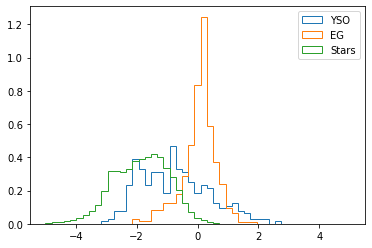

In [22]:
import matplotlib.pyplot as plt
bins= np.linspace(-5,5,20)

c2d_tar = c2d_IRAC_NEW[["Target"]].values.astype(int)
c2d_inp = c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float)
EG = np.where(c2d_tar==1)[0]
alphasEG = c2d_inp[EG].transpose()[8]

YSO = np.where(c2d_tar==0)[0]
alphasYS = c2d_inp[YSO].transpose()[8]

ST = np.where(c2d_tar==2)[0]
alphasST = c2d_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)
plt.legend()
plt.show()

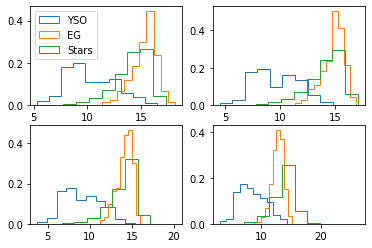

In [23]:
fig, axs = plt.subplots(2,2)
axs[0][0].hist(c2d_inp[YSO].transpose()[0],histtype='step',label='YSO',density=True)
axs[0][0].hist(c2d_inp[EG].transpose()[0],histtype='step',label='EG',density=True)
axs[0][0].hist(c2d_inp[ST].transpose()[0],histtype='step',label='Stars',density=True)
axs[0][0].legend()

axs[0][1].hist(c2d_inp[YSO].transpose()[2],histtype='step',label='YSO',density=True)
axs[0][1].hist(c2d_inp[EG].transpose()[2],histtype='step',label='EG',density=True)
axs[0][1].hist(c2d_inp[ST].transpose()[2],histtype='step',label='Stars',density=True)

axs[1][0].hist(c2d_inp[YSO].transpose()[4],histtype='step',label='YSO',density=True)
axs[1][0].hist(c2d_inp[EG].transpose()[4],histtype='step',label='EG',density=True)
axs[1][0].hist(c2d_inp[ST].transpose()[4],histtype='step',label='Stars',density=True)

axs[1][1].hist(c2d_inp[YSO].transpose()[6],histtype='step',label='YSO',density=True)
axs[1][1].hist(c2d_inp[EG].transpose()[6],histtype='step',label='EG',density=True)
axs[1][1].hist(c2d_inp[ST].transpose()[6],histtype='step',label='Stars',density=True)

plt.show()

# Rapson Data

In [25]:
df_Rap = pd.read_csv("../Data/Rapson_YSO_EG_ST.tsv",sep=';',comment='#')
df_Rap = df_Rap[df_Rap["24mag"]!='     ']
df_Rap = df_Rap[df_Rap["8mag"]!='     ']
df_Rap = df_Rap[df_Rap["5.8mag"]!='     '] 
df_Rap = df_Rap[df_Rap["4.5mag"]!='     ']
df_Rap = df_Rap[df_Rap["3.6mag"]!='     ']
df_Rap.info()

# pd.unique(df_Rap["4.5mag"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 19 to 10366
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        793 non-null    int64 
 1   RAJ2000   793 non-null    object
 2   DEJ2000   793 non-null    object
 3   3.6mag    793 non-null    object
 4   e_3.6mag  793 non-null    object
 5   4.5mag    793 non-null    object
 6   e_4.5mag  793 non-null    object
 7   5.8mag    793 non-null    object
 8   e_5.8mag  793 non-null    object
 9   8mag      793 non-null    object
 10  e_8mag    793 non-null    object
 11  24mag     793 non-null    object
 12  e_24mag   793 non-null    object
 13  Class     793 non-null    object
dtypes: int64(1), object(13)
memory usage: 92.9+ KB


In [26]:
Rap_YSO_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='0/I'],df_Rap[df_Rap["Class"]=='II'])
Rap_YSO = pd.merge_ordered(Rap_YSO_1,df_Rap[df_Rap["Class"]=='TD'])
Rap_YSO["Target"] = 0

Rap_EG_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='AGN'],df_Rap[df_Rap["Class"]=='PAH'])
Rap_EG = pd.merge_ordered(Rap_EG_1,df_Rap[df_Rap["Class"]=='SHOCK'])
Rap_EG["Target"] = 1

Rap_ST = df_Rap[df_Rap["Class"]=="III/F"]
Rap_ST["Target"] = 2

Rap_NEW_1 = pd.merge_ordered(Rap_YSO,Rap_EG)
Rap_NEW = pd.merge_ordered(Rap_NEW_1, Rap_ST)

print(f"YSO shape: {Rap_YSO.shape}")
print(f"EG shape: {Rap_EG.shape}")
print(f"Stars shape: {Rap_ST.shape}")


Rap_NEW.info()

YSO shape: (376, 15)
EG shape: (155, 15)
Stars shape: (262, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        793 non-null    int64 
 1   RAJ2000   793 non-null    object
 2   DEJ2000   793 non-null    object
 3   3.6mag    793 non-null    object
 4   e_3.6mag  793 non-null    object
 5   4.5mag    793 non-null    object
 6   e_4.5mag  793 non-null    object
 7   5.8mag    793 non-null    object
 8   e_5.8mag  793 non-null    object
 9   8mag      793 non-null    object
 10  e_8mag    793 non-null    object
 11  24mag     793 non-null    object
 12  e_24mag   793 non-null    object
 13  Class     793 non-null    object
 14  Target    793 non-null    int64 
dtypes: int64(2), object(13)
memory usage: 99.1+ KB


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_8105/2374731623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rap_ST["Target"] = 2


In [28]:
# Calculate alphas and add to be consisitent with available bands ([4.5]-[8])
Rap_NEW["alpha"] = alpha(Rap_NEW["4.5mag"].values.astype(float),Rap_NEW["24mag"].values.astype(float))

Rap_NEW.head()

,ID,RAJ2000,DEJ2000,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8mag,e_8mag,24mag,e_24mag,Class,Target,alpha
0,139,06 42 40.86,+08 46 08.84,8.64,0.002,8.54,0.002,8.40,0.002,8.36,0.002,8.29,0.043,III/F,2,-2.8025
1,419,06 43 01.03,+08 48 27.17,8.06,0.002,8.12,0.002,8.05,0.002,7.94,0.002,8.11,0.035,III/F,2,-2.9345
2,448,06 42 53.82,+08 48 41.19,9.53,0.002,9.64,0.003,9.50,0.004,9.47,0.006,9.65,0.139,III/F,2,-2.9455
3,608,06 40 37.44,+08 49 32.73,15.91,0.057,15.11,0.057,14.27,0.163,13.01,0.093,10.37,0.269,AGN,1,-0.3330
4,873,06 43 03.39,+08 50 13.12,9.52,0.002,9.55,0.003,9.44,0.003,9.40,0.005,9.59,0.139,III/F,2,-2.9620


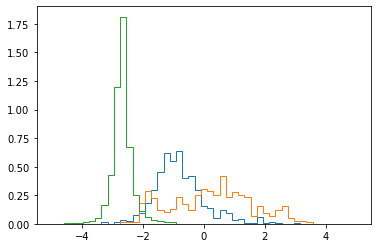

In [89]:
Rap_tar = Rap_NEW[["Target"]].values.astype(int)
Rap_inp = Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","alpha"]].values.astype(float)
EG = np.where(Rap_tar==1)[0]
alphasEG = Rap_inp[EG].transpose()[8]

YSO = np.where(Rap_tar==0)[0]
alphasYS = Rap_inp[YSO].transpose()[8]

ST = np.where(Rap_tar==2)[0]
alphasST = Rap_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)

plt.show()

In [29]:
np.save("../Data/Rap_Inputs_Test.npy",Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","24mag","e_24mag","alpha"]].values.astype(float))
np.save("../Data/Rap_Targets_Test.npy",Rap_NEW[["Target"]].values.astype(int))

# Data from CM21


If we follow the values CM21 used for each class, we should be using:
* Training
    * 1472 YSOs (331 CI and 1141 CII)
    * 857 EG (231 Gals, 529 AGN, 27 PAHs 70 Shocks)
    * 1257 Stars
* Validation
    * 613 YSOs (82 CI and 531 CII)
    * 405 EG (104 Gals, 278 AGNs, 6 PAHs, 17 Shocks)
    * 4359 Stars

We will use the above input and compare to using 1000 of each class. There are a total of:
* 3073 YSOs
* 2034 EG
* 21 796 Stars


# SPICY YSO Classification

In [5]:
df_SPICY = pd.read_csv("../Data_and_Results/SPICY_YSO_Subclasses.csv",comment='#')

df_SPICY.head()

,SPICY,RAdeg DEdeg,GLON GLAT,p1,p2,p3,class,Si,PAH,alpha,...,ag.1,ag.2,ag.3,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,WISEA,ZTFDR3
0,1,125.664811 -37.551349,255.975183 -0.253369,0.710000,,,ClassII,0,0,-1.51695368300395E+00,...,2,2,2,08223956-3733048,,,5541983493883598976,,J082239.55-373304.5,NaN
1,2,125.795513 -37.585000,256.062070 -0.187675,0.690000,,,ClassII,0,0,-6.43206342197073E-01,...,2,2,2,08231092-3735060,,,5541980848188474496,,J082310.90-373505.9,NaN
2,3,125.860244 -37.577463,256.085297 -0.141319,0.870000,,,FS,0,0,-2.14090416881411E-03,...,2,2,2,08232646-3734388,,,5541969475116705664,,J082326.45-373438.8,NaN
3,4,125.946863 -37.770809,256.282985 -0.196119,0.530000,,,ClassI,0,0,3.37295842881326E-01,...,4,2,4,,,,,,J082347.25-374615.0,NaN
4,5,126.003155 -37.126075,255.780917 0.210831,0.540000,,,FS,0,0,-2.78597489454348E-01,...,2,2,2,08240071-3707341,,,5542020537982099840,,J082400.75-370733.7,NaN


In [6]:
df_SPICY_IRAC = df_SPICY[[" SPICY","3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","class    "]]
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["8.0mag"]!='      ']
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["5.8mag"]!='      ']

df_SPICY_IRAC.head()

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS


In [11]:
df_SPICY_CI = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassI   "]
df_SPICY_CI["Target"] = 0

df_SPICY_CFS = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="FS       "]
df_SPICY_CFS["Target"] = 1

df_SPICY_CII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassII  "]
df_SPICY_CII["Target"] = 2

df_SPICY_CIII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassIII "]
df_SPICY_CIII["Target"] = 3

df_YSO_NEW_1 = pd.merge_ordered(df_SPICY_CI,df_SPICY_CII)
df_YSO_NEW_2 = pd.merge_ordered(df_SPICY_CFS,df_SPICY_CIII)
df_YSO_NEW = pd.merge_ordered(df_YSO_NEW_1,df_YSO_NEW_2)

df_YSO_NEW['alphas'] = alpha(df_YSO_NEW["4.5mag"].values.astype(float),df_YSO_NEW["8.0mag"].values.astype(float))

df_YSO_NEW.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CI["Target"] = 0
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CFS["Target"] = 1
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class,Target,alphas
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII,2,-1.52276
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII,2,-0.65028
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS,1,-0.16156
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI,0,0.32880
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS,1,-0.28620


In [12]:
Inputs = df_YSO_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","alphas"]].values.astype(float)
Targets = df_YSO_NEW[["Target"]].values.astype(float)


np.save("../Data_and_Results/Inputs_YSO_Train.npy",Inputs)
np.save("../Data_and_Results/Targets_YSO_Train.npy",Targets)

In [10]:
print(df_SPICY_CI.shape)
print(df_SPICY_CII.shape)
print(df_SPICY_CFS.shape)
print(df_SPICY_CIII.shape)

(15596, 11)
(59561, 11)
(23563, 11)
(5333, 11)
